In [1]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cp

# Problem 1 (Solutions)

In this problem, you will familiarize yourself with the basic operations with dynamical systems and useful JAX operations.

Given the following dynamics class below.

In [2]:
class Dynamics(metaclass=abc.ABCMeta):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

## (a) Setting up dynamics
Using the `Dynamics` class, construct the continuous time dynamics for the dynamically extended unicycle model.

$$
    \dot{\mathbf{x}} = \begin{bmatrix}
        \dot{x} \\ \dot{y} \\ \dot{\theta} \\ \dot{v}
    \end{bmatrix} = \begin{bmatrix}
        v\cos\theta \\ v\sin\theta \\ \omega \\ a
    \end{bmatrix}, \qquad u=(\omega, a)
$$

This problem is straightforward. We fill out the `dynamic_unicycle_ode` function so that it takes in `state` and `control` vectors and outputs the dynamics of the unicycle. In this case that means extracting the `x`, `y`, `theta`, and `v` variables from the state vectors and the `omega` and `a` variables from the control vector and then assigning them to their positions in the `xdot` vector as defined above.

In [3]:
def dynamic_unicycle_ode(state, control, time):
    """
    dynamic_unicycle_ode -- continuous‐time unicycle kinematics

    This implements the standard “unicycle” model:
      ẋ     = v * cos(θ)
      ẏ     = v * sin(θ)
      θ̇     = ω
      v̇     = a

    We fill out this function so that it:
      1. Accepts a state vector   = [x, y, θ, v]
      2. Accepts a control vector = [ω, a]
      3. Returns the time‐derivative of state (xdot vector)

    Args:
        state (array‑like, shape=(4,)):
            Current unicycle state:
              x     — x‐position
              y     — y‐position
              θ     — heading angle
              v     — forward speed
        control (array‑like, shape=(2,)):
            Control inputs:
              ω — angular velocity (steering rate)
              a — linear acceleration
        time (float):
            Current time (unused here since dynamics are time‑invariant)

    Returns:
        jnp.ndarray, shape=(4,):
            Time‐derivative [ẋ, ẏ, θ̇, v̇].
    """
    # Unpack the state components
    x, y, theta, v = state

    # Unpack the control inputs
    omega, a = control

    # Compute each derivative according to the unicycle equations
    xdot     = v * jnp.cos(theta)   # how x changes: move forward along heading
    ydot     = v * jnp.sin(theta)   # how y changes: move forward along heading
    thetadot = omega                # heading rate = angular velocity
    vdot     = a                    # speed rate = acceleration

    # Pack and return the derivative vector
    return jnp.array([xdot, ydot, thetadot, vdot])


# Specify dimensions for the Dynamics wrapper
state_dim   = 4   # number of states: x, y, θ, v
control_dim = 2   # number of controls: ω, a

# Wrap the ODE into your Dynamics class for simulation or control design
continuous_dynamics = Dynamics(dynamic_unicycle_ode, state_dim, control_dim)


## (b) Obtaining discrete-time dynamics

With the continuous time dynamics, we can obtain the discrete time dynamics by integrating over a time step $\Delta t$.

Implement both Euler integation and Runge-Kutta integration to obtain the discrete-time dynamics.

To obtain the discrete-time dynamics, that is the position of the unicycle at each time step, we can implement two methods: Euler and Runge-Kutta. Mathematically, that is we start from  
$$
\dot x = f\bigl(x(t),u(t),t\bigr),
$$
and seek $x_{k+1}$ from $(x_k,u_k)$ over step $\Delta t$.

### Forward Euler (1st order)  

$$
x_{k+1}
= x_k + \Delta t\,f\bigl(x_k,\,u_k,\,t_k\bigr).
$$

### Runge–Kutta 4 (4th order)  

$$
\begin{aligned}
k_1&=f(x_k,\,u_k,\,t_k),\\
k_2&=f\bigl(x_k+\tfrac12\Delta t\,k_1,\,u_k,\,t_k+\tfrac12\Delta t\bigr),\\
k_3&=f\bigl(x_k+\tfrac12\Delta t\,k_2,\,u_k,\,t_k+\tfrac12\Delta t\bigr),\\
k_4&=f\bigl(x_k+\Delta t\,k_3,\,u_k,\,t_k+\Delta t\bigr),\\
x_{k+1}
&=x_k+\tfrac{\Delta t}{6}\,(k_1+2k_2+2k_3+k_4)\,.
\end{aligned}
$$


In [4]:
def euler_integrate(dynamics, dt):
    """
    Create a discrete‑time integrator using the forward Euler method.

    We assume a zero‑order hold on the control input u over each step of length dt.
    That is, u is held constant between t and t+dt.

    Args:
        dynamics: callable(x, u, t) → ẋ
            The continuous‑time dynamics function, which returns the state derivative.
        dt: float
            The integration time step Δt.

    Returns:
        integrator: callable(x, u, t) → x_next
            A function that, given current state x, control u, and time t,
            returns the approximate next state x_next ≈ x(t+Δt).
    """
    def integrator(x, u, t):
        # compute state derivative at the beginning of the interval
        dx = dynamics(x, u, t)
        # forward Euler step: x_{k+1} = x_k + Δt * ẋ_k
        return x + dt * dx

    return integrator


def runge_kutta_integrator(dynamics, dt=0.1):
    """
    Create a discrete‑time integrator using the classical 4th‑order Runge–Kutta method.

    We assume a zero‑order hold on the control input u over the interval [t, t+Δt].
    RK4 provides a much more accurate approximation than Euler for the same dt.

    Args:
        dynamics: callable(x, u, t) → ẋ
            The continuous‑time dynamics function.
        dt: float
            The integration time step Δt.

    Returns:
        integrator: callable(x, u, t) → x_next
            A function that returns the next state x_{k+1} using RK4:
              k1 = f(x_k,           u, t)
              k2 = f(x_k + ½Δt k1,  u, t+½Δt)
              k3 = f(x_k + ½Δt k2,  u, t+½Δt)
              k4 = f(x_k +    Δt k3, u, t+Δt)
            and x_{k+1} = x_k + (Δt/6)(k1 + 2k2 + 2k3 + k4).
    """
    def integrator(x, u, t):
        # evaluate slopes at four points within the interval
        k1 = dynamics(x,                 u, t)
        k2 = dynamics(x + 0.5 * dt * k1, u, t + 0.5 * dt)
        k3 = dynamics(x + 0.5 * dt * k2, u, t + 0.5 * dt)
        k4 = dynamics(x +     dt * k3,  u, t +     dt)

        # combine slopes to produce next state
        return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return integrator


In [5]:
# example usage of the integrators

dt = 0.1 # timestep size

discrete_dynamics_euler = Dynamics(
    euler_integrate(continuous_dynamics, dt), state_dim, control_dim
)
discrete_dynamics_rk = Dynamics(
    runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
)

## (c) Simulating dynamics

Simulate your dynamics over 5 seconds for different values of $\Delta t$ and compare the trajectories.

Show on the same plot, the simulated trajectories for the following cases:
- Discrete-time dynamics with Euler integration, $\Delta t = 0.01$
- Discrete-time dynamics with Euler integration, $\Delta t = 0.5$
- Discrete-time dynamics with RK integration, $\Delta t = 0.01$
- Discrete-time dynamics with RK integration, $\Delta t = 0.5$

How does the choice of integration scheme and time step size influence the resulting trajectories? Feel free to try different time step values, but you don't need to submit plots of them.

the following runs the simulation for DT dynamics with Euler and RK methods with timesteps of 0.01 and 0.5 and plots the results to evaluate the accuracy of both methods.

Text(0, 0.5, 'y [m]')

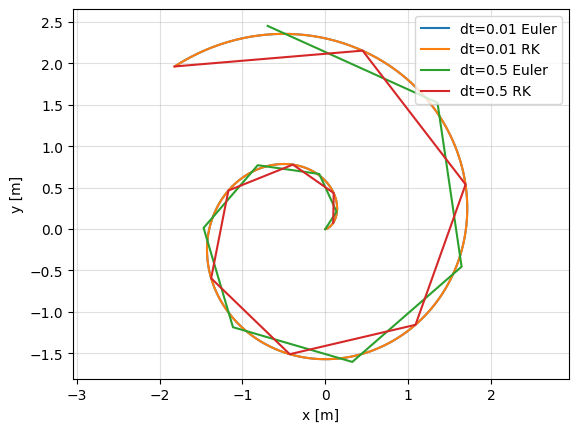

In [6]:
def simulate(dynamics, initial_state, controls, dt):
    """
    simulate -- run a discrete‐time dynamics for a sequence of controls

    Args:
        dynamics: callable(x, u, t) → x_next
            Discrete‐time dynamics function (e.g. from Euler or RK integrator).
        initial_state: array, shape (state_dim,)
            The state at time t=0.
        controls: list or array of length N
            Control inputs u₀, u₁, …, u_{N−1}.
        dt: float
            Time step between controls.

    Returns:
        x_hist: array, shape (N, state_dim)
            History of states x₀, x₁, …, x_{N−1}.
    """
    num_steps = len(controls)
    # allocate history buffer
    x_hist = jnp.zeros((num_steps, dynamics.state_dim))
    # set initial state
    x_hist = x_hist.at[0].set(initial_state)
    x = initial_state

    # step through each control input
    for i in range(num_steps):
        u = controls[i]
        # propagate state by one step
        x = dynamics(x, u, i * dt)
        # record new state
        x_hist = x_hist.at[i].set(x)

    return x_hist


# -------------------------------------------------------------------
# Now run simulations for Euler vs RK integrators and different dt
# -------------------------------------------------------------------

initial_state = jnp.array([0.0, 0.0, 0.0, 0.0])
control = jnp.array([2.0, 1.0])    # constant [ω, a] over entire horizon
duration = 5.0
dts = [0.01, 0.5]                  # time steps to compare

for dt in dts:
    num_steps = int(duration / dt)
    controls = [control] * num_steps  # same control at each step

    # build discrete‐time dynamics objects
    discrete_dynamics_euler = Dynamics(
        euler_integrate(continuous_dynamics, dt),
        state_dim, control_dim
    )
    discrete_dynamics_rk = Dynamics(
        runge_kutta_integrator(continuous_dynamics, dt),
        state_dim, control_dim
    )

    # simulate each integrator
    xs_euler = simulate(discrete_dynamics_euler, initial_state, controls, dt)
    xs_rk    = simulate(discrete_dynamics_rk,    initial_state, controls, dt)

    # plot x–y trajectories for comparison
    plt.plot(xs_euler[:, 0], xs_euler[:, 1], label=f"dt={dt} Euler")
    plt.plot(xs_rk[:,  0], xs_rk[:,  1], label=f"dt={dt} RK")

plt.legend()
plt.grid(alpha=0.4)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")


## (d) `jax.vmap`
Suppose now that you want to simulate *many* trajectories. Rather than wrapping the `simulate` function in a for loop, we can use `jax.vmap` which is a *vectorize map* function, allowing us to apply a function, in this case `simulate` over multiple inputs.

An example usage of how to use the `jax.vmap` is shown below. Notice that we can specify which argument should be vectorized and along which dimension.

The following was already given 


In [7]:
def foo(x, y, z):
    return x + y + z

N = 1000
x = jnp.array(np.random.randn(N))
y = jnp.array(np.random.randn(N))
z = jnp.array(np.random.randn(N))

xs = jnp.array(np.random.randn(N, N))
ys = jnp.array(np.random.randn(N, N))
zs = jnp.array(np.random.randn(N, N))

foo(x, y, z)  # non-vectorized version
# vectorized version for all inputs, 0 is the batch dimension for all inputs
jax.vmap(foo, in_axes=[0, 0, 0])(xs, ys, zs)

# x not batched, but ys and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, 0, 0])(x, ys, zs)

# y not batched, but xs and zs are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, None, 0])(xs, y, zs)

# z not batched, but xs and ys are with 0 as the batch dimension
jax.vmap(foo, in_axes=[0, 0, None])(xs, ys, z)

# x and y not batched, but zs is with 0 as the batch dimension
jax.vmap(foo, in_axes=[None, None, 0])(x, y, zs)

# vectorized version for all inputs, batch dimension for xs is 1,
# while 0 is the batch dimension for yx and zs
jax.vmap(foo, in_axes=[1, 0, 0])(xs, ys, zs)



Array([[-0.77392596, -0.22713774, -0.5220484 , ..., -2.6420753 ,
         1.2494938 ,  3.6306813 ],
       [ 4.276154  ,  2.8493736 ,  0.97090197, ...,  0.6313569 ,
         0.51698214, -2.1409454 ],
       [ 1.9124177 , -0.27449167,  2.5471022 , ...,  2.0537984 ,
        -0.18299723,  2.0443306 ],
       ...,
       [-1.3516538 ,  0.93780464, -1.2949059 , ...,  1.4102743 ,
         1.5282784 , -2.1499252 ],
       [ 0.89034593,  2.0473526 ,  1.2326298 , ..., -2.1035657 ,
         1.0475874 ,  0.7974895 ],
       [-0.16983718,  0.3538841 ,  1.8819399 , ..., -0.1621971 ,
        -1.5082557 ,  0.19551523]], dtype=float32)

Apply `jax.vmap` for the simulate function for the following batch of initial states and control inputs
Choose $\Delta t = 0.1$.
Use the following values and simulate multiple trajectories using the `jax.vmap` function.


the idea here is we want to run the simulation many times with different initial conditions, in this case 1000 different initial conditions. Instead of doing that with a for-loop, we use vectorized methods implemented with `jax`

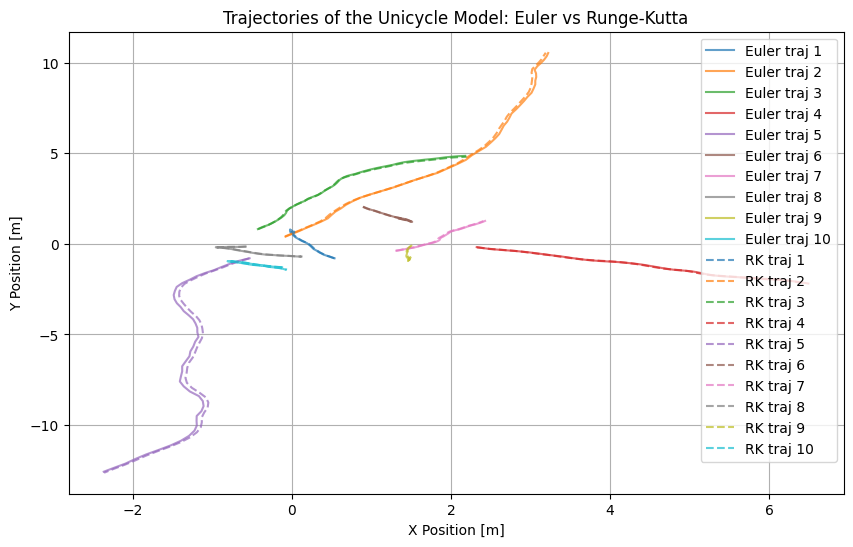

In [8]:
# -------------------------------------------------------------------
# Simulating multiple trajectories using jax.vmap
# -------------------------------------------------------------------

# Extract state and control dimensions from the continuous dynamics
state_dim = continuous_dynamics.state_dim
control_dim = continuous_dynamics.control_dim

# Number of trajectories to simulate and number of time steps per trajectory
N = 1000
n_time_steps = 50

# Generate random initial states and control inputs for the batch of trajectories
initial_states = jnp.array(np.random.randn(N, state_dim))  # shape: (N, state_dim)
controls = jnp.array(np.random.randn(N, n_time_steps, control_dim))  # shape: (N, n_time_steps, control_dim)

# Construct the discrete dynamics for a given timestep Δt
dt = 0.1
discrete_dynamics_euler = Dynamics(
    euler_integrate(continuous_dynamics, dt), state_dim, control_dim
)
discrete_dynamics_rk = Dynamics(
    runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
)

# Use jax.vmap to vectorize the simulate function for batch processing
# in_axes specifies that dynamics and dt are shared across all simulations,
# while initial_states and controls are batched along the first dimension
batched_simulate = jax.vmap(
    simulate,
    in_axes=(None, 0, 0, None),  # dynamics and dt are shared, initial_states and controls are batched
)

# Simulate trajectories for both Euler and Runge-Kutta integrators
trajs_euler = batched_simulate(discrete_dynamics_euler, initial_states, controls, dt)  # shape: (N, n_time_steps, state_dim)
trajs_rk = batched_simulate(discrete_dynamics_rk, initial_states, controls, dt)  # shape: (N, n_time_steps, state_dim)

# Extract x and y positions from the trajectories for visualization
x_euler = trajs_euler[:, :, 0]  # x positions for Euler trajectories
y_euler = trajs_euler[:, :, 1]  # y positions for Euler trajectories
x_rk = trajs_rk[:, :, 0]        # x positions for RK trajectories
y_rk = trajs_rk[:, :, 1]        # y positions for RK trajectories

# -------------------------------------------------------------------
# Plotting the trajectories for visualization
# -------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot the first 10 trajectories for Euler integration
for i in range(min(10, N)):
    plt.plot(x_euler[i, :], y_euler[i, :], label=f"Euler traj {i+1}", alpha=0.7)

# Plot the first 10 trajectories for Runge-Kutta integration
for i in range(min(10, N)):
    plt.plot(x_rk[i, :], y_rk[i, :], label=f"RK traj {i+1}", linestyle='--', alpha=0.7)

# Add plot title, labels, legend, and grid
plt.title("Trajectories of the Unicycle Model: Euler vs Runge-Kutta")
plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


### (e) `jax.jit` (optional reading)

Bleh! You notice that it takes some time to run it. And if you increased the duration or number of trajectories to simulate, the computation would increase.
If only we could compile the code to help reduce computation time. With JAX, you can! We can use the `jax.jit` function that performs just-in-time compilation. JAX will figure out the expected sizes of the input arrays and allocate memory based on that.

There are number of ways to just `jax.jit`, and it can get a bit tricky as your code becomes more complex. Best to read up the JAX documentation for more information.
But for relatively simple functions, you can usually just apply `jax.jit` without any fuss, and get significant speedup in your code.

the following was already implemented it just shows ways of increasing computational efficiency

In [9]:
# without jitting
%timeit jax.vmap(simulate, in_axes=[None, 0, 0, None])(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

3.54 s ± 619 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# method 1: directly apply jax.jit over the jax.vmap function
# need to provide the static_argnums argument to the first argument since that is a function input and not an array input
sim_jit = jax.jit(jax.vmap(simulate, in_axes=[None, 0, 0, None]), static_argnums=0)

# time the run
%timeit sim_jit(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

80.8 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# method 2: apply jax.jit over the simulate function and then apply jax.vmap
sim_jit = jax.jit(simulate, static_argnums=0)
sim_jit_vmap = jax.vmap(sim_jit, in_axes=[None, 0, 0, None])
%timeit sim_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

72.3 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Method 3: apply jax.jit over the simulate function during function construction and then apply jax.vmap
@functools.partial(jax.jit, static_argnames=("dynamics"))
def simulate(dynamics, initial_state, controls, dt):
    xs = [initial_state]
    time = 0
    for u in controls:
        xs.append(dynamics(xs[-1], u, time))
        time += dt
    return jnp.stack(xs)

sim_jit_vmap = jax.vmap(simulate, in_axes=[None, 0, 0, None])
%timeit sim_jit_vmap(discrete_dynamics_rk, initial_states, controls, jnp.array(dt)).block_until_ready()

121 ms ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
